In [1]:
from datetime import datetime
import glob, re
import lightgbm as lgb
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

from scipy import optimize
from scipy import optimize
from scipy.sparse import vstack


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

from sqlalchemy import create_engine
import pyodbc as pyodbc
from xgboost.sklearn import XGBRegressor

pd.set_option('display.precision',3)

In [2]:
data = {
    'srs': pd.read_csv('../data/heart.csv'),
    'tes': pd.read_csv('../data/heart.csv')
    }

In [3]:
data['srs'].head(3).append(data['srs'].tail(3))

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0
302,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


In [4]:
data['srs'].describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000
mean,54.366,0.683,0.967,131.624,246.264,0.149,0.528,149.647,0.327,1.040,1.399,0.729,2.314,0.545
std,9.082,0.466,1.032,17.538,51.831,0.356,0.526,22.905,0.470,1.161,0.616,1.023,0.612,0.499
min,29.000,0.000,0.000,94.000,126.000,0.000,0.000,71.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,47.500,0.000,0.000,120.000,211.000,0.000,0.000,133.500,0.000,0.000,1.000,0.000,2.000,0.000
50%,55.000,1.000,1.000,130.000,240.000,0.000,1.000,153.000,0.000,0.800,1.000,0.000,2.000,1.000
75%,61.000,1.000,2.000,140.000,274.500,0.000,1.000,166.000,1.000,1.600,2.000,1.000,3.000,1.000
max,77.000,1.000,3.000,200.000,564.000,1.000,2.000,202.000,1.000,6.200,2.000,4.000,3.000,1.000


In [5]:
data['srs'] = data['srs'].fillna(-1).infer_objects()

In [6]:
X_train = data['srs'].drop(['target'],axis=1)
#y_train = np.log1p(train['visitors'].values)
y_train = data['srs']['target']

In [9]:
scaler = StandardScaler().fit(X_train)
# scaler = MinMaxScaler().fit(x_train)

# Scale the train set
X_train = scaler.transform(X_train)
# Scale the test set
#x_test = scaler.transform(x_test)
X_train[:10,]

array([[ 0.9521966 ,  0.68100522,  1.97312292,  0.76395577, -0.25633371,
         2.394438  , -1.00583187,  0.01544279, -0.69663055,  1.08733806,
        -2.27457861, -0.71442887, -2.14887271],
       [-1.91531289,  0.68100522,  1.00257707, -0.09273778,  0.07219949,
        -0.41763453,  0.89896224,  1.63347147, -0.69663055,  2.12257273,
        -2.27457861, -0.71442887, -0.51292188],
       [-1.47415758, -1.46841752,  0.03203122, -0.09273778, -0.81677269,
        -0.41763453, -1.00583187,  0.97751389, -0.69663055,  0.31091206,
         0.97635214, -0.71442887, -0.51292188],
       [ 0.18017482,  0.68100522,  0.03203122, -0.66386682, -0.19835726,
        -0.41763453,  0.89896224,  1.23989692, -0.69663055, -0.20670527,
         0.97635214, -0.71442887, -0.51292188],
       [ 0.29046364, -1.46841752, -0.93851463, -0.66386682,  2.08204965,
        -0.41763453,  0.89896224,  0.58393935,  1.43548113, -0.37924438,
         0.97635214, -0.71442887, -0.51292188],
       [ 0.29046364,  0.681005

In [10]:
#assert X_train.isnull().sum().sum() == 0
#assert y_train.isnull().sum() == 0
#assert len(X_train) == len(y_train)
print("--- shape report ---")
print("x_train: ", X_train.shape)
print("y_train: ", y_train.shape)

--- shape report ---
x_train:  (303, 13)
y_train:  (303,)


In [11]:
seed = 123
np.random.seed(seed)
#cv = StratifiedKFold(n_splits=5, random_state=seed)


[1, 2, 4, 6, 8]


C:\Users\jingy\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\jingy\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\jingy\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[15:04:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best: 0.077812 using {'max_depth': 2, 'n_estimators': 25}
0.064055 (0.127584) with: {'max_depth': 1, 'n_estimators': 20}
0.069480 (0.138389) with: {'max_depth': 1, 'n_estimators': 25}
0.077297 (0.153959) with: {'max_depth': 2, 'n_estimators': 20}
0.077812 (0.154985) with: {'max_depth': 2, 'n_estimators': 25}
0.059668 (0.118847) with: {'max_depth': 4, 'n_estimators': 20}
0.056294 (0.112127) with: {'max_depth': 4, 'n_estimators': 25}
0.060941 (0.121382) with: {'max_depth': 6, 'n_estimators': 20}
0.058201 (0.115924) with: {'max_depth': 6, 'n_estimators': 25}
0.047953 (0.095511) with: {'max_depth': 8, 'n_estimators': 20}
0.047301 (0.094214) with: {'max_depth': 8, 'n_estimators': 25}


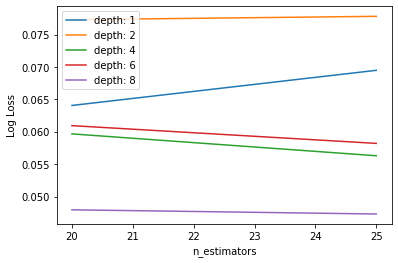

In [12]:
#Grid Search

model = XGBRegressor(learning_rate = 0.18,
                  gamma=0, subsample=0.9,
                 colsample_bytree=0.9,
                  max_delta_step = 0,
                  min_child_weight = 1,
                  colsample_bylevel =1,
                  reg_alpha = 0,
                  reg_lambda = 1,
                #  nthread = -1,
                  seed = 42)
n_estimators = [20, 25] #, 50, 100 , 150, 200]
max_depth = [1,2, 4, 6, 8]
print(max_depth)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators
                 )
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring='r2', n_jobs=-1, cv=5)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.savefig('n_estimators_vs_max_depth.png')

In [14]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, gamma=0, subsample=0.75,
                           colsample_bytree=0.9, max_depth=5)
xgb.fit(X_train,y_train)
xgb.score

[15:05:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


<bound method RegressorMixin.score of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.75, verbosity=1)>

In [15]:
from sklearn.metrics import r2_score
predictions = xgb.predict(X_train)
print(r2_score(predictions,y_train))

0.9875958111101063


In [ ]:
subXgb = pd.DataFrame({'station_name':test.station_name , 'incident_period':test.incident_period, 'predicted_incidents':prediction_results ,'incidents':0})

In [16]:
import lightgbm as lgbm
from sklearn import metrics
from sklearn import model_selection

np.random.seed(42)

model = lgbm.LGBMRegressor(
    objective='regression',
    max_depth=3,
    num_leaves=5 ** 2 - 1,
    learning_rate=0.007,
    n_estimators=300,
    min_child_samples=80,
    subsample=0.8,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=0,
    random_state=np.random.randint(10e6)
)
# Create parameters to search
gridParams = {
    'learning_rate': [0.005],
    'n_estimators': [40,400],
    'num_leaves': [6,8,12,16],
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],
    'random_state' : [501], # Updated from 'seed'
    'colsample_bytree' : [0.65, 0.66, 1],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [0,1,1.2],
    'reg_lambda' : [0,1,1.2,1.4],
    }

gbm = GridSearchCV(model, param_grid, cv=3)
gbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)
print(gbm.best_score_)

Best parameters found by grid search are: {'max_depth': 1, 'n_estimators': 25}
0.00024167246673922893


In [17]:
import lightgbm as lgbm
from sklearn import metrics
from sklearn import model_selection

np.random.seed(42)

model = lgbm.LGBMRegressor(
    objective='regression',
    max_depth=3,
    num_leaves=5 ** 2 - 1,
    learning_rate=0.007,
    n_estimators=300,
    min_child_samples=80,
    subsample=0.8,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=0,
    random_state=np.random.randint(10e6)
)

n_splits = 10
cv = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=42)

val_scores = [0] * n_splits

#sub = submission['id'].to_frame()
#sub['incidents'] = 0

feature_importances = pd.DataFrame(index=X_train.columns)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [30]:
data['srs'].columns[:13]


Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

In [21]:
X_train.shape

(303, 13)